## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, I'll read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [8]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [9]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [10]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [11]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [12]:
df[(df['landing_page'] == 'new_page') ^ (df['group'] == 'treatment')].shape[0]

3893

f. Check for missing value

In [13]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

**There is no missing value**

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.   

a. Create **df2** a dataframe wich contains only rows where **treatment** matchs with **new_page** or **control** matchs with **old_page**  


In [15]:
df2 = df[((df['landing_page'] == 'new_page') == (df['group'] == 'treatment')) | ((df['landing_page'] == 'old_page') == (df['group'] == 'control'))]
df2.shape[0]

290585

In [16]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Check duplicates **user_ids** and drop them

a. How many unique **user_id**s are in **df2**?

In [11]:
# number of unique user_ids
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.

In [17]:
df2[df2['user_id'].duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. The row information for the repeat **user_id**

In [18]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [19]:
# The information for the duplicated user_ids are the same so we can just drop one of them
df2 = df2.drop_duplicates('user_id') 
df2[df2['user_id'].duplicated()].user_id.count()

0

`4.` Calculate proportions of individual converting regardless or not the page they receives. 

a. The probability of an individual converting regardless of the page they receive.

In [20]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted:

In [16]:
actual_p_old = df2[df2['group'] == "control"].converted.mean()
actual_p_old

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted:

In [17]:
actual_p_new = df2[df2['group'] == "treatment"].converted.mean()
actual_p_new

0.11880806551510564

d. The probability that an individual received the new page.

In [18]:
df2[df2['landing_page'] == 'new_page'].shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**I can say there is evidence that the new treatment page doesn't lead to more converion because :** <br><br>
$$p(converted /control) > p(converted / Treatment)$$
$$and$$
$$proportion(Control)\approx proportion(Treatment)$$


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` We want to assume that the old page is better or equivalent to the new one unless the new page proves to be definitely better at a Type I error rate of 5%, so:

**The null hyppothesis** $H_0:$ 
     $\qquad\qquad p_{old} >= p_{new}$ <br>
**The alternative hypothesis  $H_1$ :**
  $ \qquad p_{old} < p_{new}$

`2.` We assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>

We use a sample size for each page equal to the ones in **ab_data.csv**.  <br>

We will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null. 

a. The **conversion rate** for $p_{new}$ under the null:

In [19]:
p_new = df2[df2['converted'] == 1].shape[0] / df2.shape[0]
p_new

0.11959708724499628

b. The **conversion rate** for $p_{old}$ under the null. <br>

In [20]:
p_old = df2[df2['converted'] == 1].shape[0] / df2.shape[0]
p_old

0.11959708724499628

c. The $n_{new}$, the number of individuals in the treatment group : 

In [21]:
n_new = df2[df2['group'] == "treatment"].shape[0]
n_new

145310

d. The $n_{old}$, the number of individuals in the control group : 

In [21]:
n_old = df2[df2['group'] == "control"].shape[0]
n_old

145274

e. We will simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0, 1], size=(n_new,), p=[1 - p_new, p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. We will simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0, 1], size=(n_old,), p=[1 - p_old, p_old])
old_page_converted

array([0, 0, 0, ..., 1, 0, 0])

g. The difference $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

-0.00048380320809010557

h. We will create 10,000 ($p_{new}$ - $p_{old}$) values using the same simulation process you used in parts (a) through (g) above, and store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs = []
size = df2.shape[0]
for _ in range(10000):       
    new_page_converted = np.random.choice([0, 1], size=(n_new,), p=[1 - p_new, p_new])
    old_page_converted = np.random.choice([0, 1], size=(n_old,), p=[1 - p_old, p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())


i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

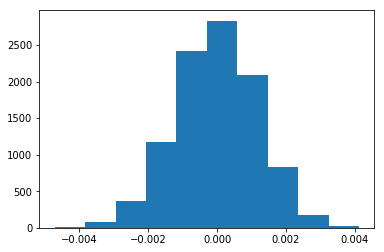

In [27]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

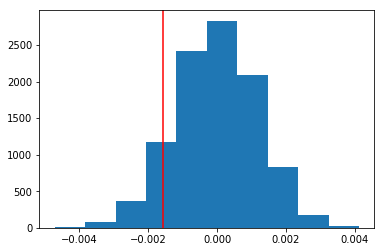

In [33]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color = 'red')

j. The proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**.


In [28]:
# actual_p_new and actual_p_old were calculated in part I
obs_diff = actual_p_new - actual_p_old
obs_diff

-0.0015782389853555567

In [32]:
# p_value calculating 
p_val = (p_diffs > obs_diff).mean()
p_val

0.90459999999999996

k.  The value computed is the p value, wich is the p value is the probability of finding the observed, or more extreme results when the null hypothesis is true
$$p_{val} > 0.05$$
<br>Conclusion: we **fail to reject the null hypothesis** 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [63]:
# prepare necessary values to calculate the p_value and the z_score using stats.proportions_ztest 
old_converted = df2[(df2['landing_page'] == "old_page") & (df2['converted'] == 1)].shape[0] 
new_converted = df2[(df2['landing_page'] == "new_page") & (df2['converted'] == 1)].shape[0] 
n_old = df2[df2['landing_page'] == "old_page"].shape[0] 
n_new = df2[df2['landing_page'] == "new_page"].shape[0]
nobs = n_old + n_new

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [64]:
from statsmodels.stats.proportion import proportions_ztest

zscore, pval = proportions_ztest(np.array([new_converted, old_converted]),np.array([n_new,n_old]), alternative = 'larger')
zscore, pval

(-1.3109241984234394, 0.90505831275902449)

n. The z-score and p-value are calculated to decide either or not reject the null hypothesis. 

$$p_{val} > 0.05$$
$$z_{score} < 1.64$$ 
nb: 1.64 is the critical value for $\alpha = 0.05$

Conclusion: **we fail to reject the nul hypothesis**


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Our prediction will result '0' or '1' so we have to use logistic regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [22]:
# set our intercept and necessary dummies column
df2['intercept'] = 1
df2[['none','ab_page']] = pd.get_dummies(df['group'])
df2 = df2.drop('none', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [32]:
# implement our logistic regression model
import statsmodels.api as sm

log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [67]:
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-12 11:43 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. The p value and the z score<br><br>**For the logistic regression model : p_val =  0.19 <br><br>
So the p value is differente from the p_value of the hypotesis test and this is because the null and the alternative hypothesis  of logistic regression are not the same as the hypothesis test ones: <br> <br>
In the logistic regression model: <br><br>
The null hypothesis : there is no relationship between variables (group) and the predicted value. $\quad H_0 : p_{old} = p_{new}$ <br>
The alternative hypothesis : there is a relationship between variables and  the predicted value** $\qquad H_1 : p_{old} \neq p_{new}$

f. Now, we are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**We can consider other factors influencing on the conversion rate as gender, range of age or timestamp.
The disadvantage here is that can disturb our conclusion about wich page leads to more conversion (the new or the old one).**

g. Does it appear that country had an impact on conversion?  <br>
We will add the countries as an additional variable to improve our model.

In [24]:
# Import the country dataframe 
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [29]:
# Join the country column regarding the user_id 
df3 = df2.join(df_country.set_index('user_id'), on='user_id')
df3.head(0)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country


In [30]:
# Create df4 wich is the df3 with the necessary dummies columns for our new model
country = pd.get_dummies(df3['country'])
country.head()
df3 =pd.concat([df3, country],axis=1)
df4 = df3.drop(['timestamp', 'group', 'landing_page','country', 'CA'], axis = 1)
df4.head()

,user_id,converted,intercept,ab_page,UK,US
0,851104,0,1,0,0,1
1,804228,0,1,0,0,1
2,661590,0,1,1,0,1
3,853541,0,1,1,0,1
4,864975,1,1,0,0,1


In [33]:
### Fit Your Linear Model And Obtain the Results
log_mod = sm.Logit(df4['converted'], df4[['intercept', 'ab_page', 'UK', 'US']])

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [72]:
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-12 11:43 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

From the summary we can make some observations :<br> 
1- The value for ab_page become larger.<br>
2- The p value for UK and US are large.<br><br>
**Conclusion :** the results obtained from countries information are statistacaly insignificant.

i. In this phase we will use **the interaction between ab_page and the countries**

In [34]:
### Create the necessary dummy variables
df3['ab_UK'] = df3['ab_page']*df3['UK']
df3['ab_US'] = df3['ab_page']*df3['US']
df3['ab_CA'] = df3['ab_page']*df3['CA']
df3.head() 

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,ab_UK,ab_US,ab_CA
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0


In [35]:
# we will create df5 wich is df3 without unecessary columns
df5 = df3.drop(['timestamp', 'group', 'landing_page','country', 'CA'], axis = 1)
df5.head()

,user_id,converted,intercept,ab_page,UK,US,ab_UK,ab_US,ab_CA
0,851104,0,1,0,0,1,0,0,0
1,804228,0,1,0,0,1,0,0,0
2,661590,0,1,1,0,1,0,1,0
3,853541,0,1,1,0,1,0,1,0
4,864975,1,1,0,0,1,0,0,0


In [36]:
# Fit our model and show results
log_mod = sm.Logit(df5['converted'], df5[['intercept', 'ab_page', 'UK', 'US','ab_UK','ab_US','ab_CA']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 9


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
======================================================================
Model:                Logit             No. Iterations:    9.0000     
Dependent Variable:   converted         Pseudo R-squared:  0.000      
Date:                 2020-06-13 04:12  AIC:               212782.6602
No. Observations:     290584            BIC:               212846.1381
Df Model:             5                 Log-Likelihood:    -1.0639e+05
Df Residuals:         290578            LL-Null:           -1.0639e+05
Converged:            1.0000            Scale:             1.0000     
----------------------------------------------------------------------
           Coef.    Std.Err.     z     P>|z|     [0.025       0.975]  
----------------------------------------------------------------------
intercept -2.0040      0.0364 -55.0077 0.0000      -2.0754     -1.9326
ab_page   -0.0193 198692.2786  -0.0000 1.0000 -389429.7293 389429.6907
UK         0.0118      0.0398   0.2957 0.7674      -0.0663      0.0899
US         0.0175      0.0377   0.4652 0.6418      -0.0563      0.0914
ab_UK      0.0301 198692.2786   0.0000 1.0000 -389429.6799 389429.7401
ab_US     -0.0013 198692.2786  -0.0000 1.0000 -389429.7113 389429.7087
ab_CA     -0.0482 198692.2786  -0.0000 1.0000 -389429.7581 389429.6618
======================================================================

"""

p vlues for interactive variables are large, so we conclude that they are statistically insignificant

# Conclusion

In this project we have done an A/B test for a dataset to studies the comportment of individual conversions regarding the page received by the individual (old or new) in the first time and we added the country factor.

<br>
We started by exploring the dataset by investigating the structure of the dataset and by calculating some usefull probabilities.
<br>

After that we did a hypothesis test where we conclude to **fail to reject the null hypothesis** (The null hypothesis was that the old page was better or equivalent to the new one).
<br>

Finally we made a logistic regression model, this phase was due on two steps:
    <br>1- With the ab_page factor only:
<br> This time the null hypothesis was **"there is no relationship between the reception of new or old page and the predicted value"**.
<br> 2- With the country as an additional variable:
<br> We started by ab_page and country separatly, after that we made added an **interactional variables between the both**, and in each case we concluded the **statisticall insignificance** of the country factor. <br>
And in the both cases we conclude by **failing to reject the null hypothesis**


## Limitations
The main limitation I had was the technical skills and the time.